# Load data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1074 non-null   datetime64[ns]
 1   Cprice      1074 non-null   float64       
 2   Eprice      1074 non-null   float64       
 3   BrentOil    1074 non-null   float64       
 4   CrudeOilF   1074 non-null   float64       
 5   TTF-NatGas  1074 non-null   float64       
 6   NatGasF     1074 non-null   float64       
 7   Coal        1074 non-null   float64       
 8   GasolineF   1074 non-null   float64       
 9   DJI         1074 non-null   float64       
 10  S&P500      1074 non-null   float64       
 11  USD-EUR     1074 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 100.8 KB
None
        Date  Cprice     Eprice  BrentOil  CrudeOilF  TTF-NatGas  NatGasF  \
0 2018-07-09   15.85  50.688929     78.07      73.85      22.730    2.828   


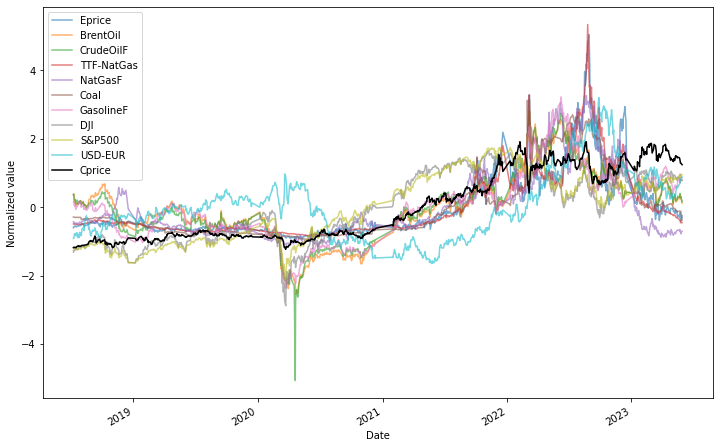

(1074, 1)
(1074, 11)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

df = pd.read_excel('data/df_eu.xlsx', sheet_name='Sheet1')

# overview of data
print(df.info())
print(df.head())

# normalize to make the plot more readable
df_norm = df.set_index('Date')
df_norm = (df_norm - df_norm.mean()) / df_norm.std()
dataNormY = df_norm['Cprice']
dataNormX = df_norm.iloc[:,1:]
dataNormX.plot(figsize=(12,8), x_compat=True, alpha=0.6)
dataNormY.plot(color='black', label='Cprice', legend=True)
plt.ylabel('Normalized value')
plt.show()

# Cprice series
df['Cprice'].plot()
plt.show()

# load
dataY = np.array(df['Cprice']).reshape(-1,1)
dataX = np.array(df.iloc[:,1:]) # carbon price at the previous time step is also used as feature
t = range(len(dataY))
print(dataY.shape) # (len, 1)
print(dataX.shape) # (len, n_comp)

## Naive Decompose

(1074,) (1074,)


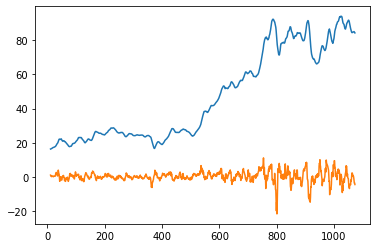

In [15]:
trendY = df['Cprice'].rolling(12).mean()
residY = df['Cprice'] - trendY
trendY.plot()
residY.plot()
print(trendY.shape, residY.shape)

# Rolling window

In [16]:
win_len = 200
val_num = 100
pred_len = 10

i = 60

t = len(dataY) - win_len - pred_len - val_num + i
win_real = dataY[t+win_len : t+win_len+pred_len] # (pred_len, 1)
winY = dataY[t:t+win_len, :]
winX = dataX[t:t+win_len, :] # (win_len, n_comp)

244    2019-08-30
245    2019-09-02
246    2019-09-03
247    2019-09-06
248    2019-09-09
          ...    
1039   2023-03-30
1040   2023-03-31
1041   2023-04-03
1042   2023-04-04
1043   2023-04-06
Name: Date, Length: 800, dtype: datetime64[ns]


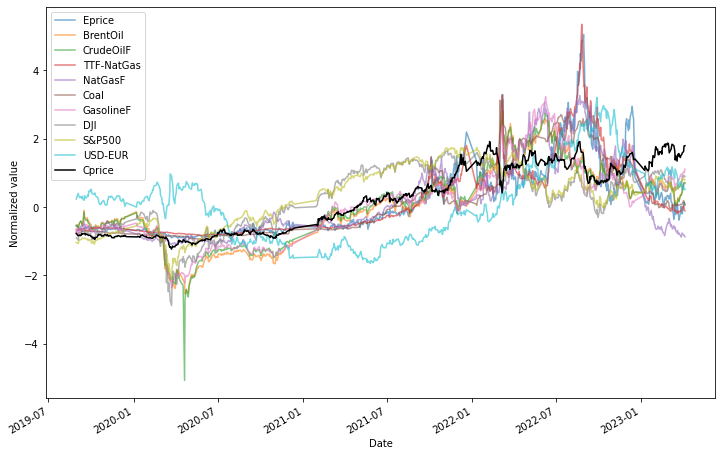

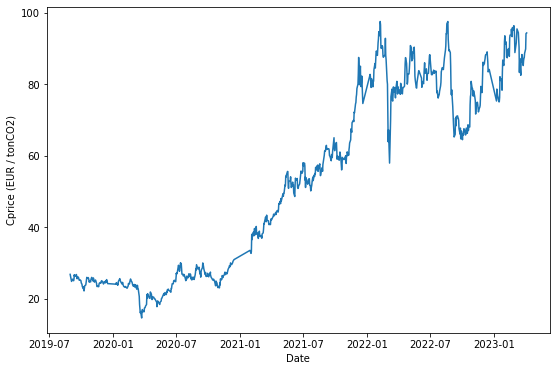

In [3]:
print(df['Date'][t:t+win_len])
dataNormY = df_norm['Cprice'][t:t+win_len]
dataNormX = df_norm.iloc[:,1:][t:t+win_len]
# dataDate = df['Date'][t:t+win_len]
dataNormX.plot(figsize=(12,8), x_compat=True, alpha=0.6)
dataNormY.plot(color='black', label='Cprice', legend=True)
plt.ylabel('Normalized value')
plt.show()

plt.figure(figsize=(9,6))
plt.plot(df['Date'][t:t+win_len] , winY)
plt.xlabel('Date')
plt.ylabel('Cprice (EUR / tonCO2)')
plt.show()

# Single

## SARIMAX

In [4]:
from sarimax import *


# exog = winX[:,1:] # NOTE: SARIMAX contains AR terms, so the carbon price at the previous time step is not used as a feature
exog = None # no future exog available for out sample prediction, so only model with y
endog = winY

>>> orig series <<<
Results of Dickey-Fuller Test:
Test Statistic                  -0.433038
p-value                          0.904435
#Lags Used                      13.000000
Number of Observations Used    786.000000
Critical Value (1%)             -3.438697
Critical Value (5%)             -2.865224
Critical Value (10%)            -2.568732
dtype: float64


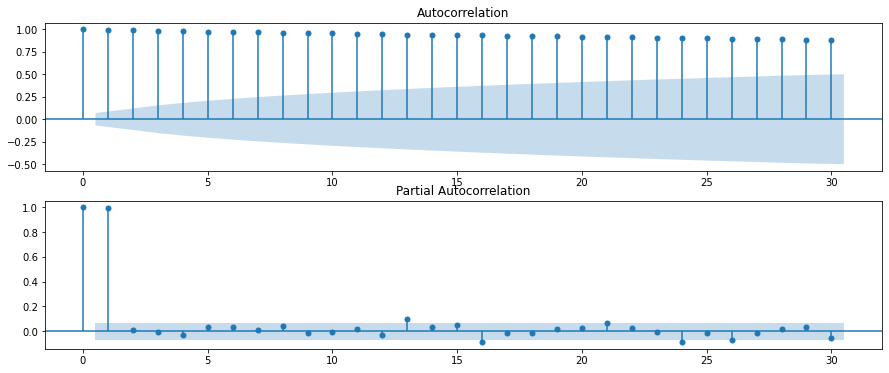

>>> diff(1) <<<
Results of Dickey-Fuller Test:
Test Statistic                -9.367912e+00
p-value                        7.512886e-16
#Lags Used                     1.200000e+01
Number of Observations Used    7.860000e+02
Critical Value (1%)           -3.438697e+00
Critical Value (5%)           -2.865224e+00
Critical Value (10%)          -2.568732e+00
dtype: float64


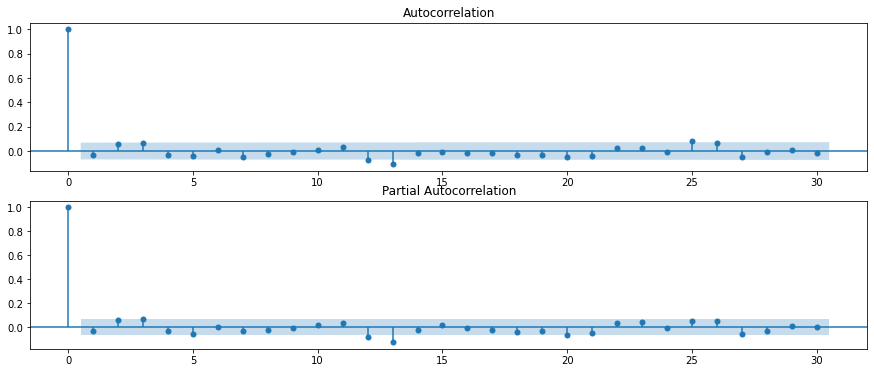

In [5]:
### Test for stationary
print('>>> orig series <<<')
ADF_ACF_PACF(endog)
print('>>> diff(1) <<<')
ADF_ACF_PACF(np.diff(endog.reshape(-1)))


In [17]:
### manually fit the model
# sweep for the best params
d = 1
# grid search
p = range(5)
q = range(5)
orders = (d,p,q)
aic_mat, bic_mat = sweepSARIMAX(endog, orders, exog=exog)
f = open("sarimax_mat.pkl", "wb")
pickle.dump((aic_mat, bic_mat), f)
f.close()
# f = open("sarimax_mat.pkl", "rb")
# aic_mat, bic_mat = pickle.load(f)
# f.close()


p = 0,q = 
0 1 2 3 4 
min aic for now: 3219.532055, corresponding (p,q): (0,4)
min bic for now: 3231.184342, corresponding (p,q): (0,1)

p = 1,q = 
0 1 2 3 4 
min aic for now: 3219.532055, corresponding (p,q): (0,4)
min bic for now: 3231.184342, corresponding (p,q): (0,1)

p = 2,q = 
0 1 2 3 4 
min aic for now: 3219.532055, corresponding (p,q): (0,4)
min bic for now: 3231.184342, corresponding (p,q): (0,1)

p = 3,q = 
0 1 2 3 4 
min aic for now: 3219.532055, corresponding (p,q): (0,4)
min bic for now: 3231.184342, corresponding (p,q): (0,1)

p = 4,q = 
0 1 2 3 4 
min aic for now: 3219.532055, corresponding (p,q): (0,4)
min bic for now: 3231.184342, corresponding (p,q): (0,1)


min aic: 3220.000000, corresponding (p,q): (0,4)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  799
Model:               SARIMAX(0, 1, 4)   Log Likelihood               -1604.766
Date:                Thu, 27 Jul 2023   AIC                           3219.532
Time:                        23:26:56   BIC                           3242.943
Sample:                             0   HQIC                          3228.526
                                - 799                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0276      0.849     -1.210      0.226      -2.692       0.636
ma.L2          0.1038      0.039      2.639      0.008       0.027       0.181
ma.L3         -0.0079      0.072     -0.110      0.9

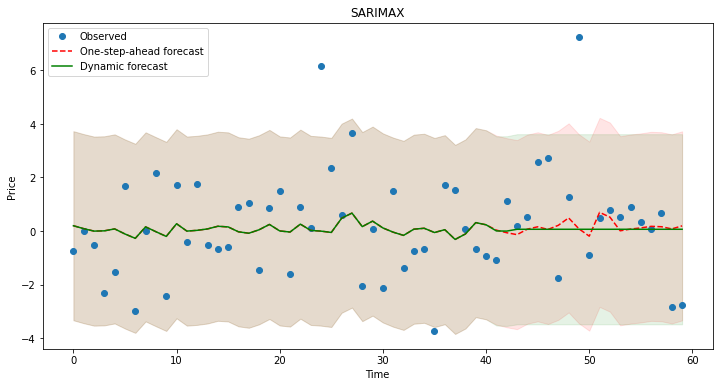

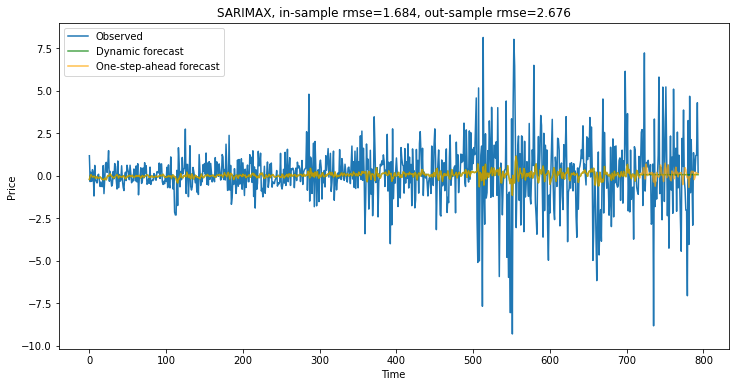

In [18]:
p,q = bestSARIMAX(aic_mat, bic_mat, cri='aic')
model = sm.tsa.statespace.SARIMAX(endog, exog, order=(p,d,q)).fit(disp=False)

### visualize performance
print(model.summary())
plot_prediction(model, endog)

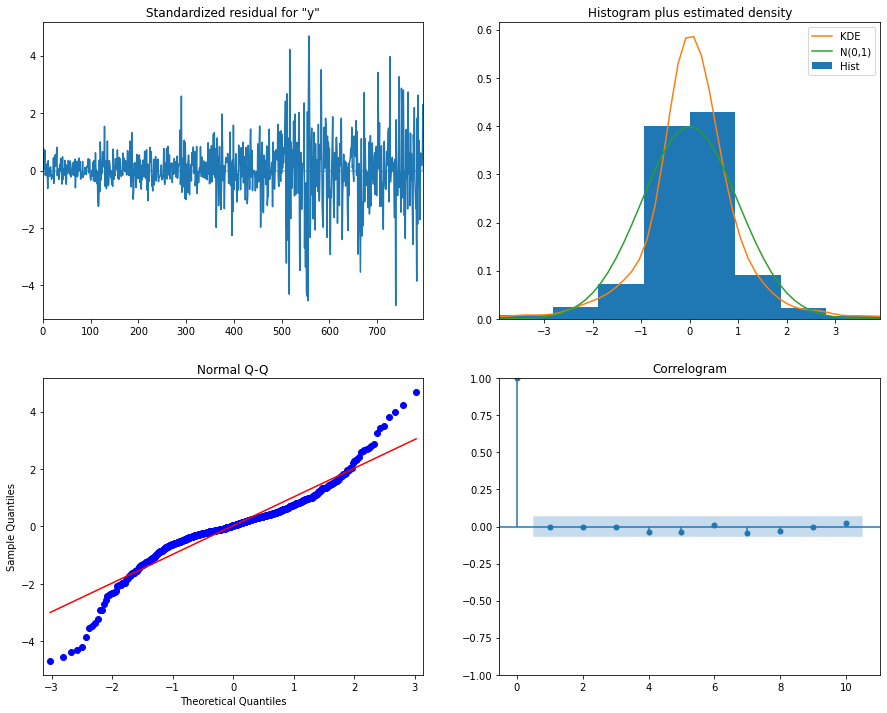

            AC          Q  Prob(>Q)
lag                                
1.0  -0.003795   0.011551  0.914412
2.0  -0.006275   0.043167  0.978648
3.0  -0.001738   0.045597  0.997446
4.0  -0.034536   1.005799  0.908915
5.0  -0.040388   2.320605  0.803236
6.0   0.008479   2.378624  0.881797
7.0  -0.042478   3.836700  0.798383
8.0  -0.028619   4.499384  0.809495
9.0  -0.000670   4.499747  0.875559
10.0  0.025675   5.034445  0.888865
11.0  0.043266   6.554807  0.833906
12.0 -0.076190  11.275469  0.505470


In [19]:
### model diagnostics
model.plot_diagnostics(figsize=(15,12))
plt.show()
# LjungBox test
r,q,p = sm.tsa.acf(model.resid.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p][:12]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

In [20]:
### multi-step prediction

pred, model = forecast_arima(endog, pred_len=10)

print(model.summary())
print(pred)


p = 0,q = 
0 1 2 3 4 
min aic for now: 3215.512252, corresponding (p,q): (0,3)
min bic for now: 3228.689439, corresponding (p,q): (0,1)

p = 1,q = 
0 1 2 3 4 
min aic for now: 3214.413777, corresponding (p,q): (1,4)
min bic for now: 3228.614565, corresponding (p,q): (1,0)

p = 2,q = 
0 1 2 3 4 
min aic for now: 3208.155295, corresponding (p,q): (2,2)
min bic for now: 3228.614565, corresponding (p,q): (1,0)

p = 3,q = 
0 1 2 3 4 
min aic for now: 3208.155295, corresponding (p,q): (2,2)
min bic for now: 3228.614565, corresponding (p,q): (1,0)

p = 4,q = 
0 1 2 3 4 
min aic for now: 3208.155295, corresponding (p,q): (2,2)
min bic for now: 3228.614565, corresponding (p,q): (1,0)
min aic: 3208.000000, corresponding (p,q): (2,2)
2 2 0


array([ 0.37626982, -0.49565719, -0.27308945,  0.53374799,  0.16550461,
       -0.55060588, -0.05762274,  0.54674161, -0.04665429, -0.52338554])

array([94.3, 94.3, 94.3, 94.3, 94.3, 94.3, 94.3, 94.3, 94.3, 94.3])

## SVR

RMSE: 2.5618911754464007
R2: 0.9073719169883745


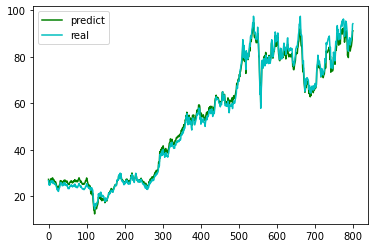

In [22]:
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
scalerY = StandardScaler()
x = scalerX.fit_transform(winX)
y = scalerY.fit_transform(winY)

clf = SVR(kernel='linear', C=1.25)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25, shuffle=False)
clf.fit(x_train, y_train)

y_hat = clf.predict(x)
y_test_hat = clf.predict(x_test)
y = scalerY.inverse_transform(y)
y_hat = scalerY.inverse_transform(y_hat)
y_test = scalerY.inverse_transform(y_test)
y_test_hat = scalerY.inverse_transform(y_test_hat)

print("RMSE:", cal_rmse(y_test, y_test_hat))
print("R2:", r2_score(y_test, y_test_hat))

plt.plot(y_hat, 'g', label="predict")
plt.plot(y, 'c', label="real")
plt.legend()
plt.show()

## nn-models

### bpnn

epoch 001 train_loss 1.72032193 val_loss 0.05076960
epoch 002 train_loss 0.03863023 val_loss 0.02646741
epoch 003 train_loss 0.03311481 val_loss 0.02607462
epoch 004 train_loss 0.04133379 val_loss 0.07021595
EarlyStopping counter: 1 out of 7
epoch 005 train_loss 21.67018420 val_loss 0.25578498
EarlyStopping counter: 2 out of 7
epoch 006 train_loss 0.15797308 val_loss 0.10054776
EarlyStopping counter: 3 out of 7
epoch 007 train_loss 0.07324325 val_loss 0.07979467
EarlyStopping counter: 4 out of 7
epoch 008 train_loss 0.05532648 val_loss 0.09161291
EarlyStopping counter: 5 out of 7
epoch 009 train_loss 0.07026849 val_loss 0.09056167
EarlyStopping counter: 6 out of 7
epoch 010 train_loss 0.11540882 val_loss 0.10588550
EarlyStopping counter: 7 out of 7
Early stopping
performance of step-MLP
col 0: RMSE=7.70, MAPE=12.41%
col 1: RMSE=6.71, MAPE=12.74%
col 2: RMSE=9.17, MAPE=12.55%
col 3: RMSE=5.72, MAPE=11.16%
col 4: RMSE=10.68, MAPE=15.08%
col 5: RMSE=9.95, MAPE=14.37%
col 6: RMSE=6.33, MAP

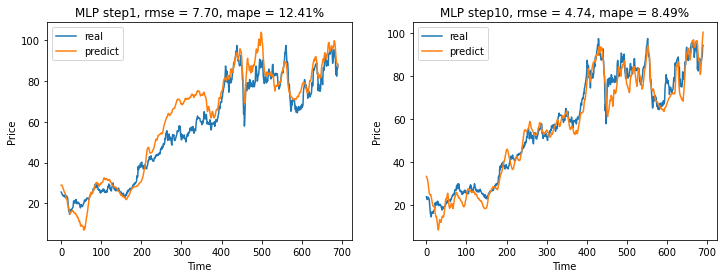

In [8]:
from models import *
batch_size = 1

model_name = 'MLP'
m = BPNN_model('step-'+model_name, batch_size)

pred = m.predict(winX, winY, seq_len=100, pred_len=10)
pred, real = m.apply_model(False)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(real[:,0], label="real")
plt.plot(pred[:,0], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step1, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,0],pred[:,0]), cal_mape(real[:,0],pred[:,0])))
plt.subplot(122)
plt.plot(real[:,9], label="real")
plt.plot(pred[:,9], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step10, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,9],pred[:,9]), cal_mape(real[:,9],pred[:,9])))
plt.show()

In [18]:
from torchsummary import summary
summary(m.model, (100*11,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          55,050
              ReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 10]             510
Total params: 55,560
Trainable params: 55,560
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


### gru

model step-GRU loaded from file
performance of step-GRU
col 0: RMSE=1.76, MAPE=2.63%
col 1: RMSE=1.70, MAPE=2.49%
col 2: RMSE=1.65, MAPE=2.45%
col 3: RMSE=1.80, MAPE=2.73%
col 4: RMSE=1.93, MAPE=2.87%
col 5: RMSE=1.82, MAPE=2.72%
col 6: RMSE=1.77, MAPE=2.71%
col 7: RMSE=1.73, MAPE=2.65%
col 8: RMSE=1.82, MAPE=2.74%
col 9: RMSE=2.07, MAPE=2.85%


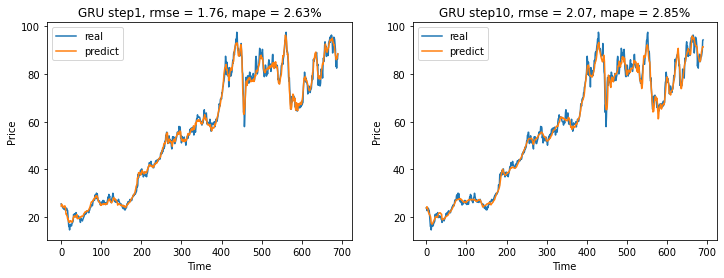

In [20]:
from models import *
batch_size = 1

model_name = 'GRU'
m = GRU_model('step-'+model_name, batch_size)

# pred = m.predict(winX, winY, seq_len=100, pred_len=10)
m.prepare_data(winX, winY, seq_len=100, pred_len=10)
m.init_model()
m.load_model('step-'+model_name)
pred, real = m.apply_model(False)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(real[:,0], label="real")
plt.plot(pred[:,0], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step1, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,0],pred[:,0]), cal_mape(real[:,0],pred[:,0])))
plt.subplot(122)
plt.plot(real[:,9], label="real")
plt.plot(pred[:,9], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step10, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,9],pred[:,9]), cal_mape(real[:,9],pred[:,9])))
plt.show()

In [27]:
from torchsummary import summary
summary(m.model, (100,11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 100, 10], [-1, 2, 10]]               0
            Linear-2                   [-1, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.00
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


### LSTM

epoch 001 train_loss 0.00658976 val_loss 0.00635250
epoch 002 train_loss 0.00639333 val_loss 0.00588945
epoch 003 train_loss 0.00624050 val_loss 0.00597826
EarlyStopping counter: 1 out of 7
epoch 004 train_loss 0.00622471 val_loss 0.00601689
EarlyStopping counter: 2 out of 7
epoch 005 train_loss 0.00618192 val_loss 0.00607464
EarlyStopping counter: 3 out of 7
epoch 006 train_loss 0.00613756 val_loss 0.00611398
EarlyStopping counter: 4 out of 7
epoch 007 train_loss 0.00609912 val_loss 0.00617551
EarlyStopping counter: 5 out of 7
epoch 008 train_loss 0.00606071 val_loss 0.00620360
EarlyStopping counter: 6 out of 7
epoch 009 train_loss 0.00602896 val_loss 0.00625620
EarlyStopping counter: 7 out of 7
Early stopping
performance of step-LSTM
col 0: RMSE=1.87, MAPE=2.87%
col 1: RMSE=1.92, MAPE=2.97%
col 2: RMSE=1.94, MAPE=3.03%
col 3: RMSE=1.98, MAPE=3.05%
col 4: RMSE=2.03, MAPE=3.10%
col 5: RMSE=2.08, MAPE=3.17%
col 6: RMSE=2.02, MAPE=3.14%
col 7: RMSE=1.91, MAPE=3.08%
col 8: RMSE=1.98, MAPE

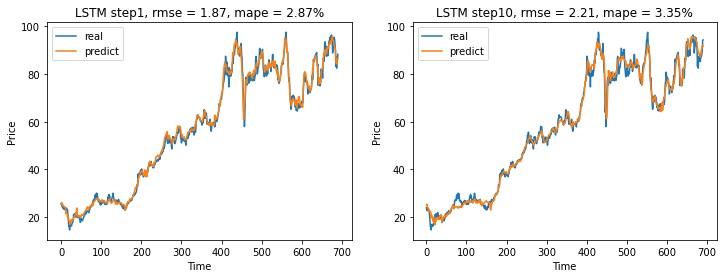

In [49]:
from models import *
batch_size = 1

model_name = 'LSTM'
m = LSTM_model('step-'+model_name, batch_size)

pred = m.predict(winX, winY, seq_len=100, pred_len=10)
pred, real = m.apply_model(False)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(real[:,0], label="real")
plt.plot(pred[:,0], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step1, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,0],pred[:,0]), cal_mape(real[:,0],pred[:,0])))
plt.subplot(122)
plt.plot(real[:,9], label="real")
plt.plot(pred[:,9], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step10, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,9],pred[:,9]), cal_mape(real[:,9],pred[:,9])))
plt.show()

### TCN

epoch 001 train_loss 0.01080398 val_loss 0.01030660
epoch 002 train_loss 0.01106362 val_loss 0.01049410
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.01054110 val_loss 0.01035224
EarlyStopping counter: 2 out of 7
epoch 004 train_loss 0.01128288 val_loss 0.01062255
EarlyStopping counter: 3 out of 7
epoch 005 train_loss 0.01092880 val_loss 0.01054650
EarlyStopping counter: 4 out of 7
epoch 006 train_loss 0.01063712 val_loss 0.01049932
EarlyStopping counter: 5 out of 7
epoch 007 train_loss 0.01136525 val_loss 0.01070102
EarlyStopping counter: 6 out of 7
epoch 008 train_loss 0.01024430 val_loss 0.01075585
EarlyStopping counter: 7 out of 7
Early stopping
performance of step-TCN
col 0: RMSE=2.08, MAPE=2.97%
col 1: RMSE=2.12, MAPE=3.03%
col 2: RMSE=2.20, MAPE=3.07%
col 3: RMSE=2.37, MAPE=3.27%
col 4: RMSE=2.42, MAPE=3.42%
col 5: RMSE=2.47, MAPE=3.57%
col 6: RMSE=2.50, MAPE=3.69%
col 7: RMSE=2.56, MAPE=3.87%
col 8: RMSE=2.75, MAPE=4.17%
col 9: RMSE=3.02, MAPE=4.49%


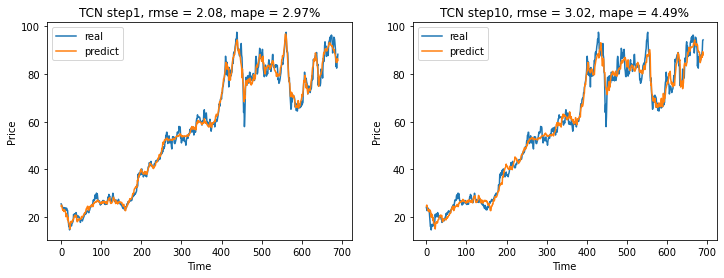

In [9]:
from models import *
batch_size = 1

model_name = 'TCN'
m = TCN_model('step-'+model_name, batch_size)

pred = m.predict(winX, winY, seq_len=100, pred_len=10)
pred, real = m.apply_model(False)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(real[:,0], label="real")
plt.plot(pred[:,0], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step1, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,0],pred[:,0]), cal_mape(real[:,0],pred[:,0])))
plt.subplot(122)
plt.plot(real[:,9], label="real")
plt.plot(pred[:,9], label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+' step10, rmse = %.2f, mape = %.2f%%' %(cal_rmse(real[:,9],pred[:,9]), cal_mape(real[:,9],pred[:,9])))
plt.show()

# ))) report plot

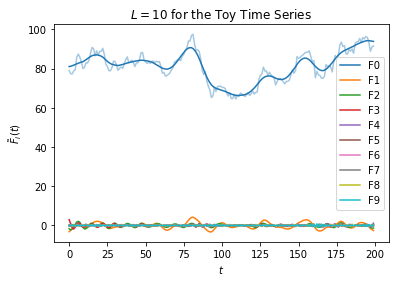

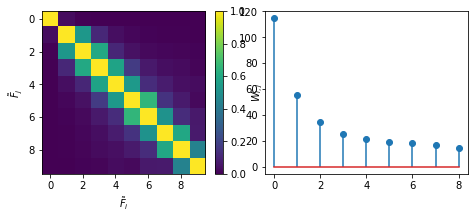

In [26]:
from ssa import SSA

# decompose with ssa
n_decomp = 10
n_integr = 6
series = winY.reshape(-1)

ssa = SSA(series, n_decomp)
# ssa.denoising()

ssa.components_to_df().plot()
ssa.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L={}$ for the Toy Time Series".format(n_decomp))
plt.show()

plt.figure(figsize=(8,3))
plt.subplot(121)
ssa.plot_wcorr()
plt.subplot(122)
plt.stem(ssa.Sigma[1:])
plt.show()

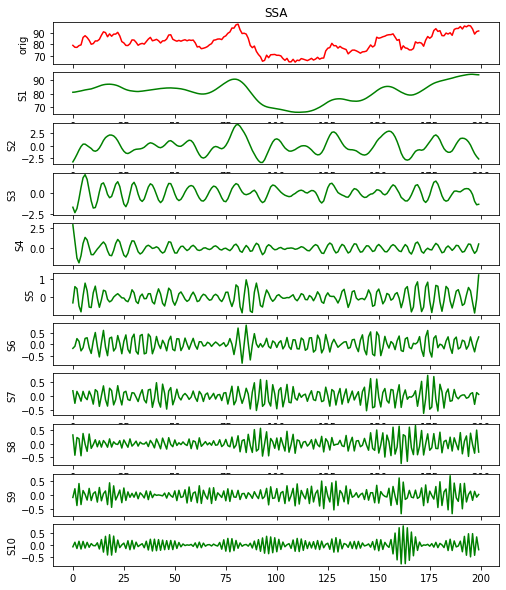

In [18]:
imfs = ssa.components_to_df()
ncomp = imfs.shape[1]
fig, axes = plt.subplots(ncomp+1, 1, figsize=(8,10))
# orig
ax = axes[0]
ax.set_title('SSA')
ax.plot(ssa.orig_TS, 'r')
ax.set_ylabel('orig')
# decomposed
for i in range(ncomp):
    ax = axes[i+1]
    ax.plot(imfs.iloc[:,i], 'g')
    ax.set_ylabel('S%d' %(i+1))

In [ ]:
from models import *

m = TCN_model('TCN-ssa', 1)

pred = m.predict(winX, winY, seq_len=100, pred_len=1)
pred, real = m.apply_model(False)

plt.figure(figsize=(8,4))
plt.plot(real, label="real")
plt.plot(pred, label="predict")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title(model_name+', rmse = %.2f, mape = %.2f%%' %(cal_rmse(real,pred), cal_mape(real,pred)))
plt.show()

In [11]:
len(dataY)

1074

7.959981652450693e-15
7.832102143740586e-15


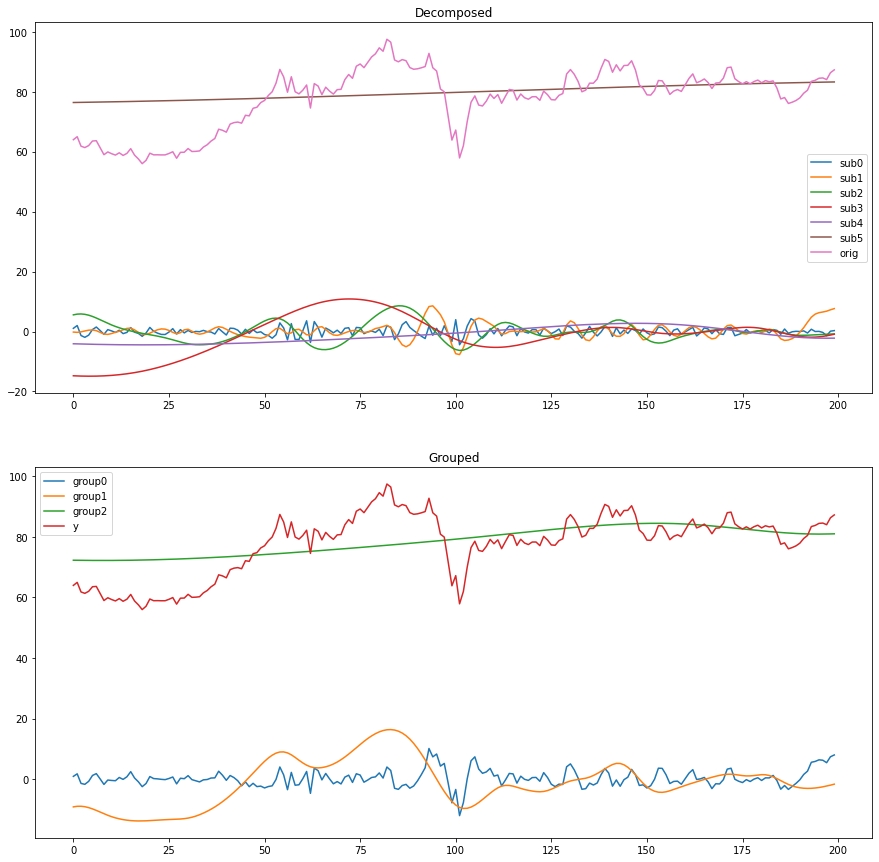

In [14]:
from series_restr import *

dataY = dataY.reshape(-1)
win_x = dataY[700:900]

imfs = decomp_ceemdan(win_x)
reconstr = integr_fuzzen_pwlf(imfs, n_integr=3)
vis_restr(imfs, reconstr, win_x)




In [8]:
### ssa
reconstr = restr_ssa(win_x, n_decomp=10, n_integr=3, vis=True)

2.435033428336451e-13
2.4349984400735135e-13


# Rolling window

In [3]:
win_len = 500
print(len(y)-win_len-1)

t = 1000
win_x = y[t:t+win_len]
win_y = y[t+win_len]

# win_xs = []
# win_ys = []
# for t in range(len(y)-win_len-1):
#     win_xs.append(y[t:t+win_len])
#     win_ys.append(y[t+win_len])
# print(np.array(win_xs).shape)

# t = 500
# win_x = win_xs[t]
# win_y = win_ys[t]

1664


## Restructuring

1.0366986530680488e-14
1.0184738491945744e-14


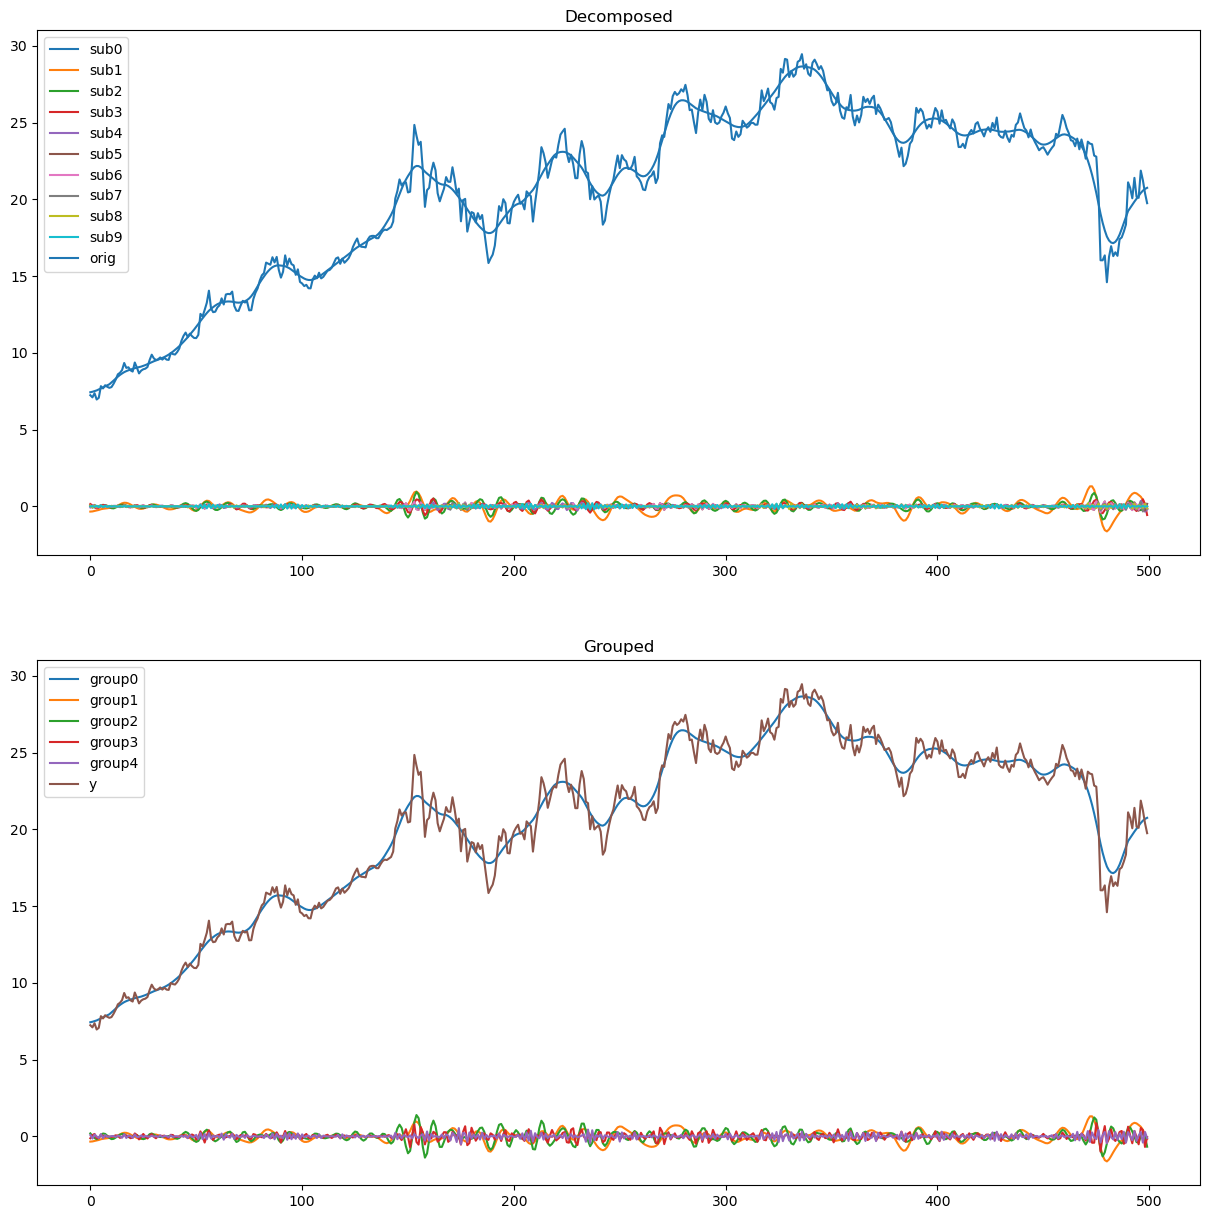

In [7]:
from series_restr import *

# ### EMD++
# # decompose
# imfs = decomp_ceemdan(win_x)
# # imfs = decomp_eemd(win_x)
# # imfs = decomp_emd(win_x)

# # integrate
# reconstr = integr_fuzzen_pwlf(imfs, n_integr=2)
# # reconstr = integr_fine_to_coarse(imfs)
# # reconstr = integr_fuzzen_threshold(imfs)

# vis_restr(imfs, reconstr, win_x)


### ssa
reconstr = restr_ssa(win_x, n_decomp=10, n_integr=5, vis=True)

1.4787207069590148e-14
1.4768057983301562e-14


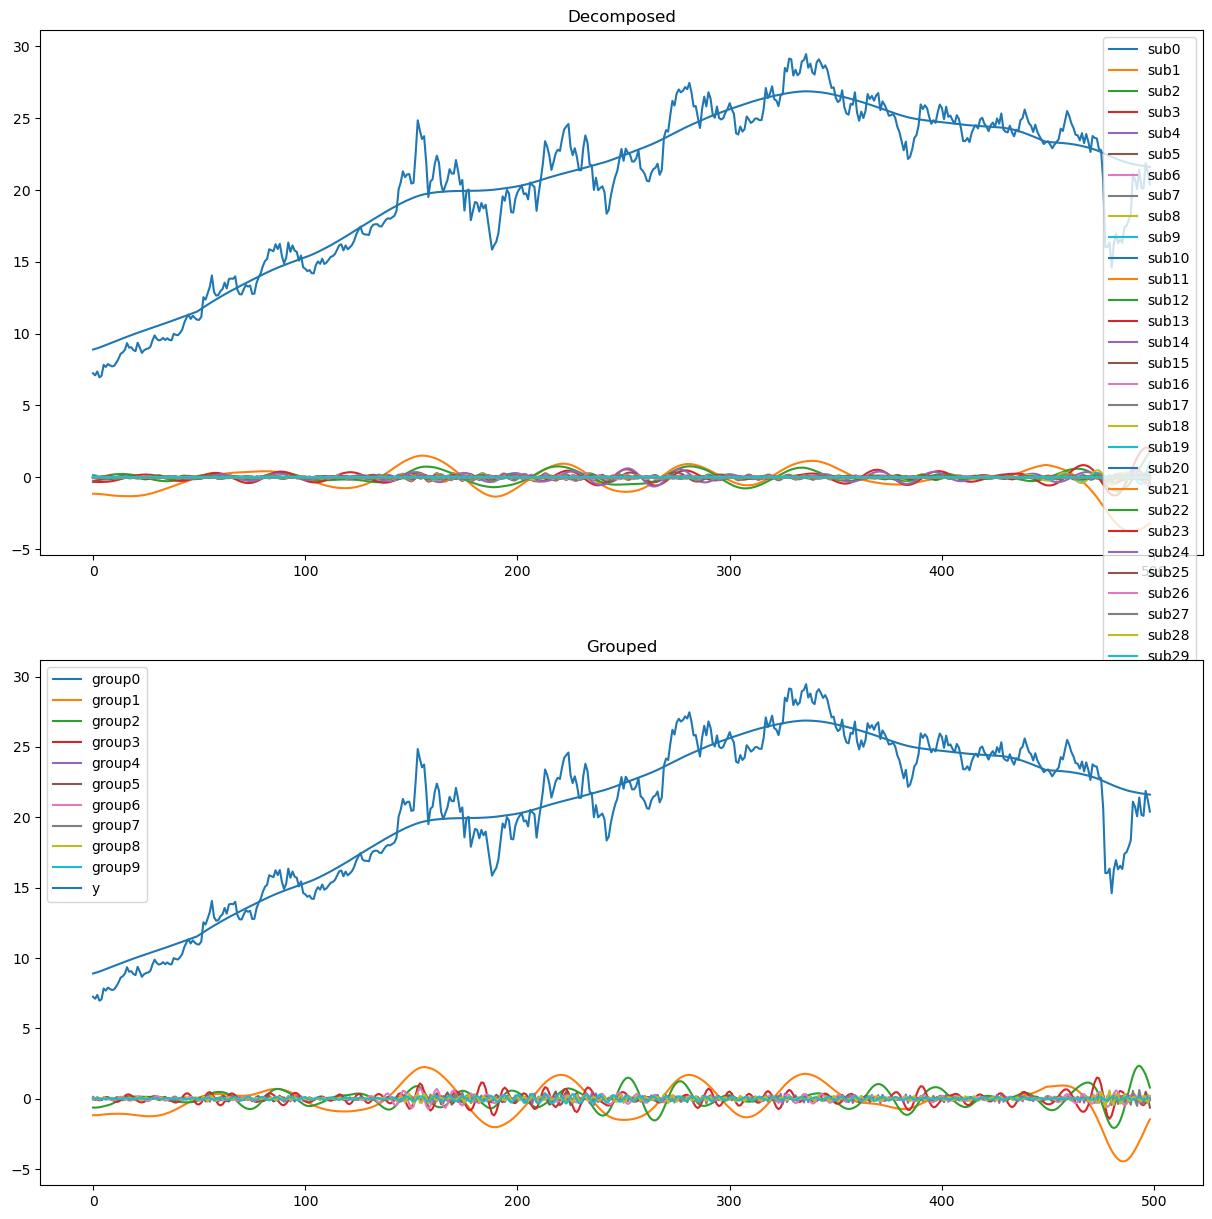

In [4]:
reconstr1 = restr_ssa(win_x[:-1], n_decomp=50, n_integr=10, vis=True)

In [5]:
# for i in range(10):
#     plt.figure()
#     plt.plot(reconstr[:,:-1][i])
#     plt.plot(reconstr1[i])
#     plt.show()
#     print(np.sum(np.abs(reconstr[:,:-1][i]-reconstr1[i]))/200)


from sarimax import *
for i in range(10):
    hi_freq = reconstr1[i]
    LjungBox = stattools.q_stat(stattools.acf(hi_freq)[1:11],len(hi_freq))
    print(LjungBox[1][0])

4.852427666830467e-110
7.264606525573094e-110
1.4525552975849547e-104
5.3673860659408235e-81
2.8463215785461056e-87
4.2844109180493415e-09
5.345458327907087e-56
5.373652947165951e-25
0.023874333175139924
6.435121429172973e-36


data\restructured\restr_win200_sam1_ssa.pkl


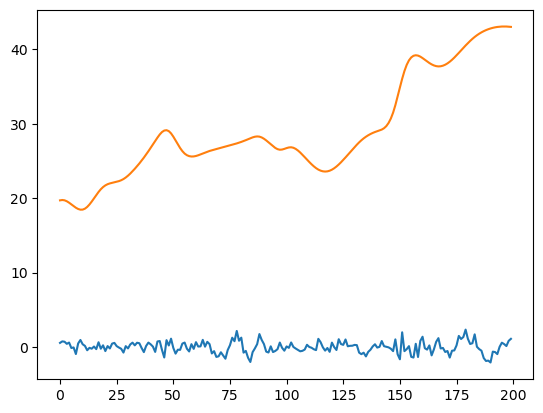

In [10]:
import pickle

restr = 'ssa' # 'ssa', 'ceemdan'
decomp_datapath = 'data\\restructured\\restr_win%d_sam1_%s.pkl' %(win_len, restr)
print(decomp_datapath)
f = open(decomp_datapath, "rb")
_, win_restrs, win_ys = pickle.load(f)
f.close()

reconstr_ssa = win_restrs[t]

for i in range(reconstr.shape[0]):
    plt.plot(reconstr[i])

data\restructured\restr_win200_sam1_ceemdan.pkl


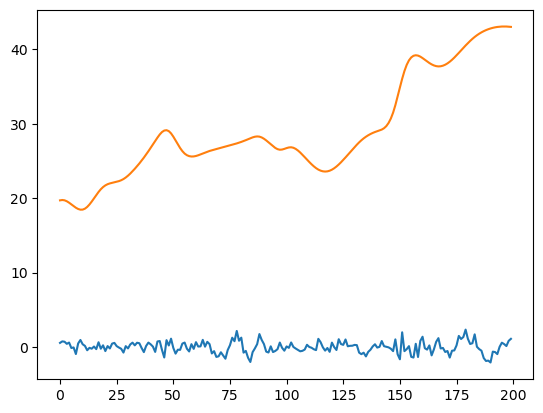

In [11]:
import pickle

restr = 'ceemdan' # 'ssa', 'ceemdan'
decomp_datapath = 'data\\restructured\\restr_win%d_sam1_%s.pkl' %(win_len, restr)
print(decomp_datapath)
f = open(decomp_datapath, "rb")
_, win_restrs, win_ys = pickle.load(f)
f.close()

reconstr_ceemdan = win_restrs[t]

for i in range(reconstr.shape[0]):
    plt.plot(reconstr[i])

## High-freq forecast with ARIMA

In [11]:
# with HiddenPrints():
#     pred, model_arima = forecast_arima(win_x)
# print(pred)
# print(win_y)

3.339189842661835e-17
0.12126075396231895
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 415.136
Date:                Mon, 12 Jun 2023   AIC                           -818.273
Time:                        19:17:13   BIC                           -798.483
Sample:                             0   HQIC                          -810.264
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0777      0.016    -68.159      0.000      -1.109      -1.047
ar.L2         -0.9682      0.013    -76.312      0.000      -0.993      -0.943
ma.L1     

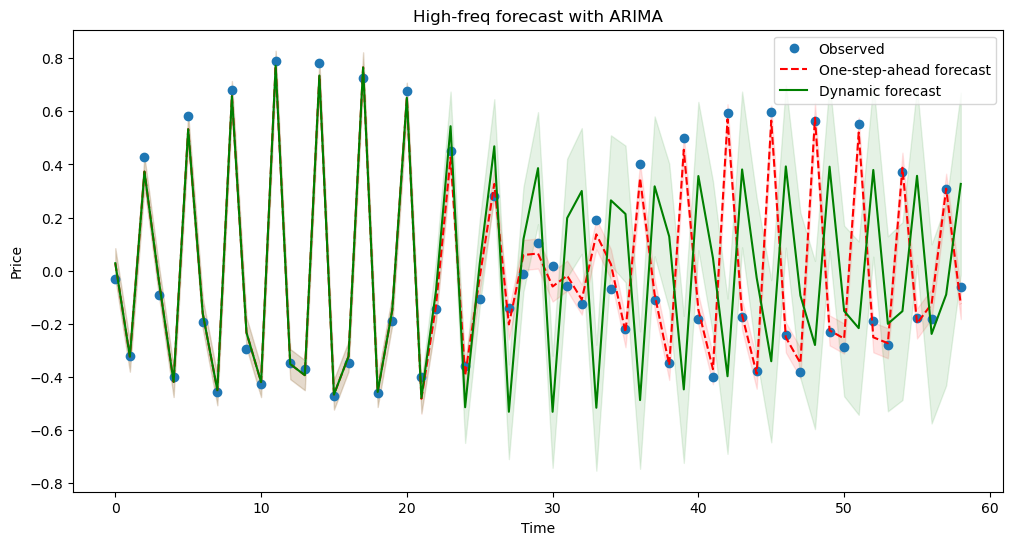

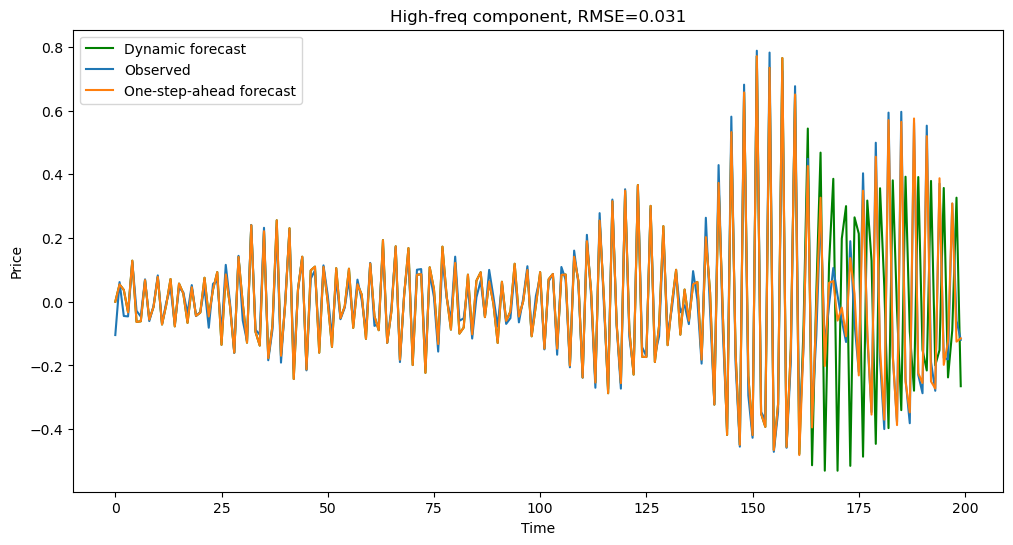

In [59]:
from sarimax import *
hi_freq = reconstr[1,:]

print(stattools.adfuller(hi_freq)[1])

with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
print(hi_freq_pred)

plot_prediction(model_arima, hi_freq)

1.1780651256187027e-06
0.07289145195401209
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 4)   Log Likelihood                 222.375
Date:                Mon, 12 Jun 2023   AIC                           -430.751
Time:                        15:55:59   BIC                           -407.663
Sample:                             0   HQIC                          -421.407
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4971      0.059     25.365      0.000       1.381       1.613
ar.L2         -0.7470      0.059    -12.688      0.000      -0.862      -0.632
ma.L1    

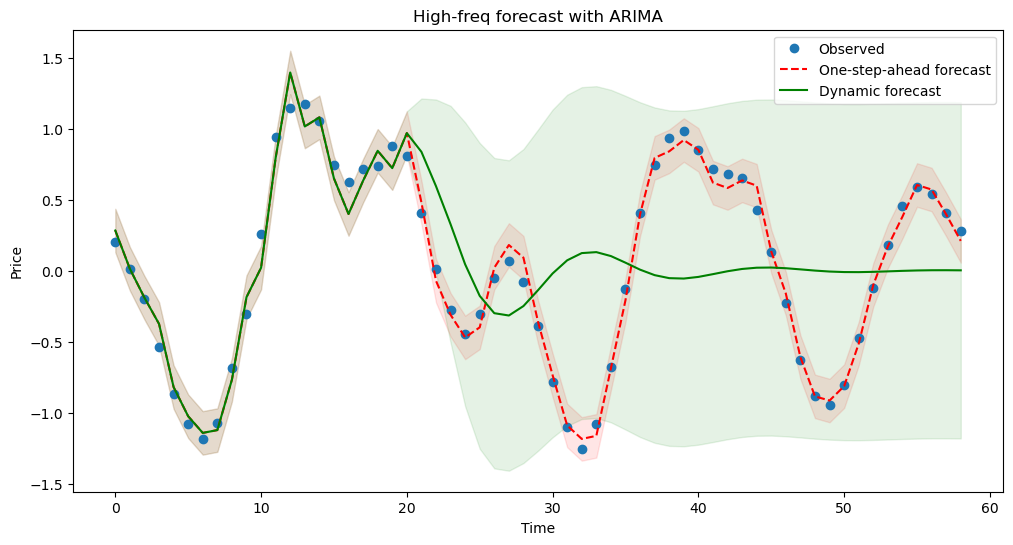

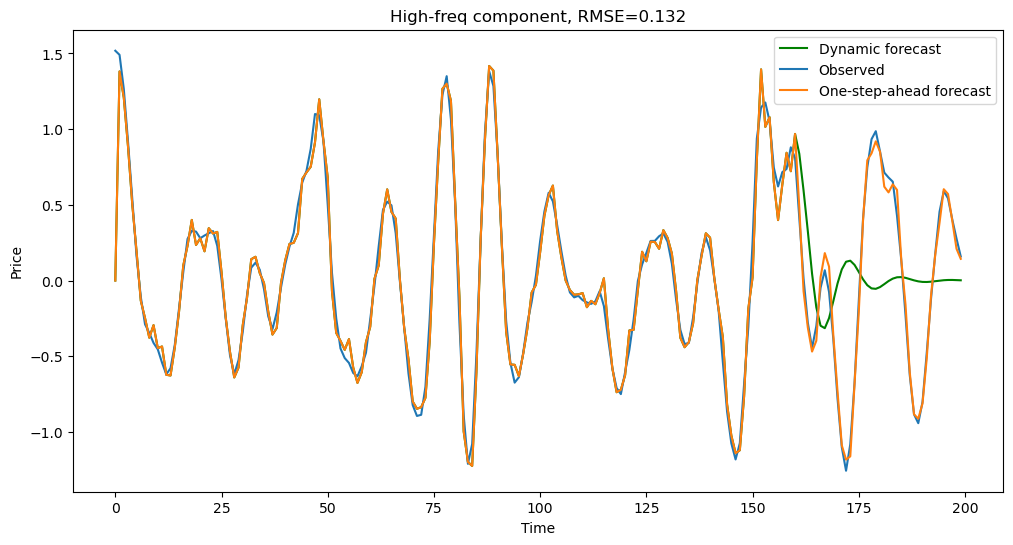

In [16]:
from sarimax import *
hi_freq = reconstr_ssa[1,:]

print(stattools.adfuller(hi_freq)[1])

with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
print(hi_freq_pred)

plot_prediction(model_arima, hi_freq)

4.3223398496273203e-10
0.7816916881290576
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -203.676
Date:                Mon, 12 Jun 2023   AIC                            417.351
Time:                        15:56:10   BIC                            433.843
Sample:                             0   HQIC                           424.025
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6878      0.080     21.168      0.000       1.532       1.844
ar.L2         -0.7988      0.081     -9.860      0.000      -0.958      -0.640
ma.L1     

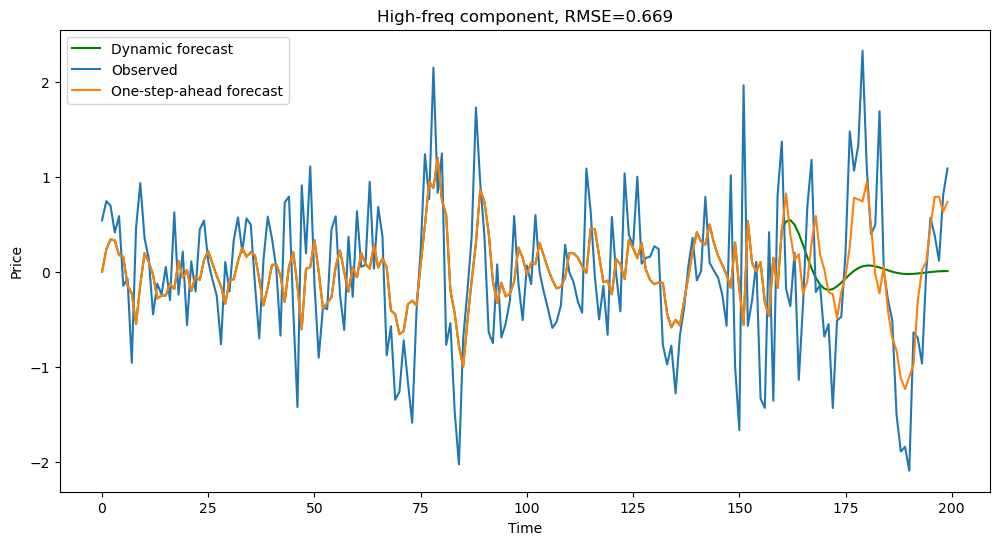

In [17]:
from sarimax import *
hi_freq = reconstr_ceemdan[0,:]

print(stattools.adfuller(hi_freq)[1])

with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
print(hi_freq_pred)

plot_prediction(model_arima, hi_freq)

## ARIMA-GARCH

In [34]:
# for orig series (hi_freq)

from statsmodels.tsa.stattools import adfuller #ADF单位根检验
from statsmodels.tsa import stattools #白噪声检验:Ljung-Box检验

# 平稳性检验
result = adfuller(hi_freq)
print(result[1]) # 小于0.05，拒绝原假设，原序列不存在单位根，即原序列平稳

# 白噪声检验
LjungBox = stattools.q_stat(stattools.acf(hi_freq)[1:12],len(hi_freq)) #显示第1个到第11个白噪声检验的p值
LjungBox[1]  #所有p值小于0.05，因此拒绝原假设，原序列不是白噪声，原序列具有ARCH效应

1.3683610589243767e-15


array([8.23526844e-59, 2.45379862e-78, 2.06460071e-82, 1.94366588e-81,
       4.98233773e-81, 1.89533642e-80, 6.40107115e-80, 1.38664946e-79,
       5.29793013e-80, 5.98436679e-84, 8.15797526e-93])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -364.368
Date:                Wed, 07 Jun 2023   AIC                            736.735
Time:                        15:55:29   BIC                            753.593
Sample:                             0   HQIC                           743.350
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6740      0.026     65.105      0.000       1.624       1.724
ar.L2         -0.7399      0.024    -30.367      0.000      -0.788      -0.692
ma.L1         -0.9406      0.018    -52.312      0.0

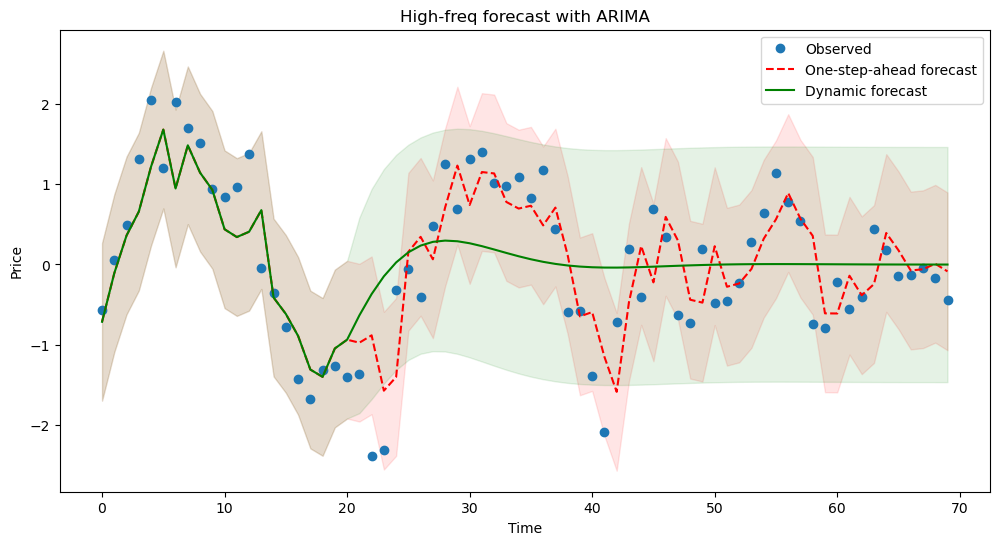

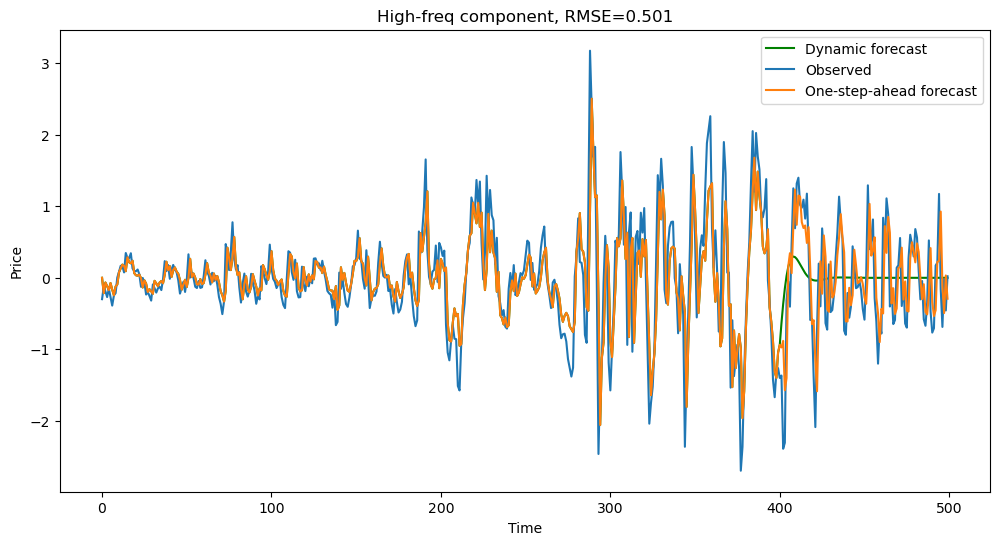

In [35]:
# fit arima
with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
plot_prediction(model_arima, hi_freq)

In [60]:
plt.plot(model_arima.resid)

In [38]:
# 残差
resid = model_arima.resid

# 平稳性检验
result = adfuller(resid)
print(result[1]) # 小于0.05，拒绝原假设，残差不存在单位根，即残差平稳

# 白噪声检验
LjungBox = stattools.q_stat(stattools.acf(resid**2)[1:12],len(resid)) #显示第1个到第11个白噪声检验的p值
LjungBox[1]  #所有p值小于0.05，因此拒绝原假设，残差平方不是白噪声，残差具有ARCH效应

4.891185153141113e-08


array([1.33867856e-07, 3.86683586e-08, 2.20551616e-09, 8.45364285e-13,
       5.72569054e-20, 1.29635887e-23, 4.12803194e-25, 3.94532127e-25,
       5.56189834e-26, 2.96997308e-27, 1.67267719e-30])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 234.18386222908032
            Iterations: 16
            Function evaluations: 125
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -234.184
Distribution:                  Normal   AIC:                           480.368
Method:            Maximum Likelihood   BIC:                           505.655
                                        No. Observations:                  500
Date:                Wed, Jun 07 2023   Df Residuals:                      499
Time:                        16:38:39   Df Model:                            1
                                  Mean Model                                 


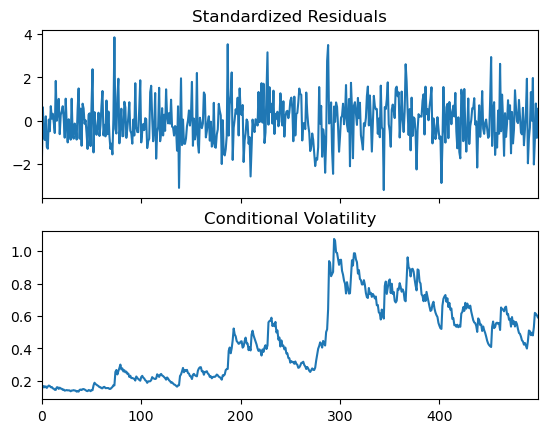

In [63]:
# 进行 GARCH 建模
from arch import arch_model

model_garch = arch_model(y=resid, p=2,q=2) #默认模型为GARCH（1，1）
model_garch = model_garch.fit(update_freq=0) #估计参数
print(model_garch.summary())
model_garch.plot();


In [67]:
model_garch.forecast(horizon=3, start=0).mean

h.1       h.2       h.3
0   -0.010437 -0.010437 -0.010437
1   -0.010437 -0.010437 -0.010437
2   -0.010437 -0.010437 -0.010437
3   -0.010437 -0.010437 -0.010437
4   -0.010437 -0.010437 -0.010437
..        ...       ...       ...
495 -0.010437 -0.010437 -0.010437
496 -0.010437 -0.010437 -0.010437
497 -0.010437 -0.010437 -0.010437
498 -0.010437 -0.010437 -0.010437
499 -0.010437 -0.010437 -0.010437

[500 rows x 3 columns]

In [68]:
print(model_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -234.184
Distribution:                  Normal   AIC:                           480.368
Method:            Maximum Likelihood   BIC:                           505.655
                                        No. Observations:                  500
Date:                Wed, Jun 07 2023   Df Residuals:                      499
Time:                        16:38:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0104  1.354e-02     -0.771      0.441 

## Low-freq forecast

In [22]:
# data preparation helper
from nn_models import *

lo_freq = reconstr[-1,:]


### BPNN

In [13]:
lo_freq_pred, model_bpnn = forecast_BPNN(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00002533 val_loss 0.00000406
epoch 002 train_loss 0.00002391 val_loss 0.00000416
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00002085 val_loss 0.00000287
epoch 004 train_loss 0.00001954 val_loss 0.00000243
epoch 005 train_loss 0.00001867 val_loss 0.00000235
epoch 006 train_loss 0.00001791 val_loss 0.00000252
EarlyStopping counter: 1 out of 7
epoch 007 train_loss 0.00001735 val_loss 0.00000299
EarlyStopping counter: 2 out of 7
epoch 008 train_loss 0.00001697 val_loss 0.00000372
EarlyStopping counter: 3 out of 7
epoch 009 train_loss 0.00001676 val_loss 0.00000455
EarlyStopping counter: 4 out of 7
epoch 010 train_loss 0.00001668 val_loss 0.00000529
EarlyStopping counter: 5 out of 7
epoch 011 train_loss 0.00001666 val_loss 0.00000586
EarlyStopping counter: 6 out of 7
epoch 012 train_loss 0.00001667 val_loss 0.00000626
EarlyStopping counter: 7 out of 7
Early stopping


25.602404

In [14]:
# visualize
Dtr, _, _, scalar = prepare_data_BPNN(lo_freq, seq_len=30, random=False)
vis_model_performance(model_bpnn, Dtr, scalar)

### LSTM

In [15]:
lo_freq_pred, model_lstm = forecast_LSTM(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00000184 val_loss 0.00000040
epoch 002 train_loss 0.00000184 val_loss 0.00000101
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00000150 val_loss 0.00000034
epoch 004 train_loss 0.00000113 val_loss 0.00000295
EarlyStopping counter: 1 out of 7
epoch 005 train_loss 0.00000126 val_loss 0.00000460
EarlyStopping counter: 2 out of 7
epoch 006 train_loss 0.00000131 val_loss 0.00000510
EarlyStopping counter: 3 out of 7
epoch 007 train_loss 0.00000136 val_loss 0.00000518
EarlyStopping counter: 4 out of 7
epoch 008 train_loss 0.00000138 val_loss 0.00000554
EarlyStopping counter: 5 out of 7
epoch 009 train_loss 0.00000137 val_loss 0.00000594
EarlyStopping counter: 6 out of 7
epoch 010 train_loss 0.00000137 val_loss 0.00000628
EarlyStopping counter: 7 out of 7
Early stopping


25.479486

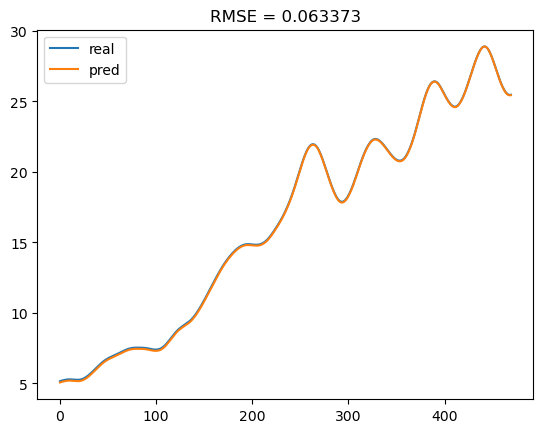

In [16]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(lo_freq, seq_len=30, random=False)
vis_model_performance(model_lstm, Dtr, scalar)

### GRU

In [17]:
lo_freq_pred, model_gru = forecast_GRU(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00000080 val_loss 0.00000028
epoch 002 train_loss 0.00000086 val_loss 0.00000035
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00000096 val_loss 0.00000519
EarlyStopping counter: 2 out of 7
epoch 004 train_loss 0.00000108 val_loss 0.00001324
EarlyStopping counter: 3 out of 7
epoch 005 train_loss 0.00000124 val_loss 0.00000030
EarlyStopping counter: 4 out of 7
epoch 006 train_loss 0.00000064 val_loss 0.00001194
EarlyStopping counter: 5 out of 7
epoch 007 train_loss 0.00000109 val_loss 0.00000341
EarlyStopping counter: 6 out of 7
epoch 008 train_loss 0.00000085 val_loss 0.00001093
EarlyStopping counter: 7 out of 7
Early stopping


25.423796

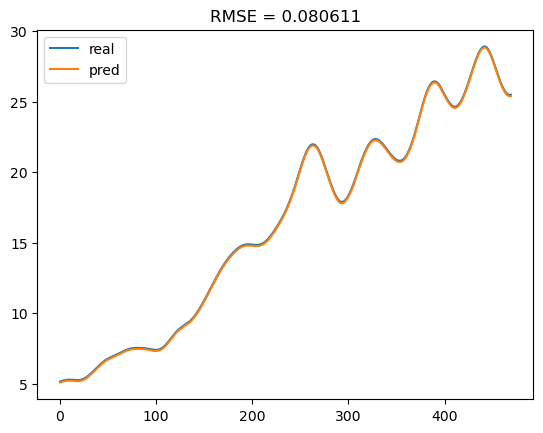

In [18]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(lo_freq, seq_len=30, random=False)
vis_model_performance(model_gru, Dtr, scalar)

### TCN

-0.04885796


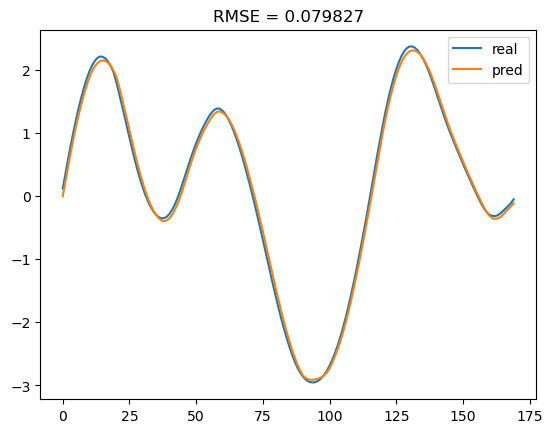

In [54]:
lo_freq = reconstr[-2,:]

with HiddenPrints():
    lo_freq_pred, model_tcn = forecast_TCN(lo_freq)

print(lo_freq_pred)

# visualize
Dtr, _, _, scalar = prepare_data_TCN(lo_freq, seq_len=30, random=False)
vis_model_performance(model_tcn, Dtr, scalar)

43.03791


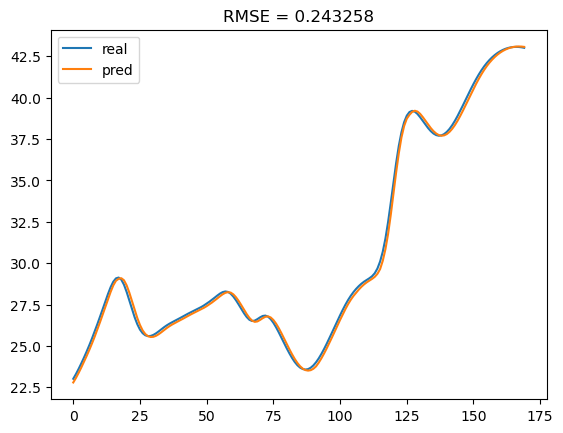

In [29]:
lo_freq = reconstr_ceemdan[-1,:]

with HiddenPrints():
    lo_freq_pred, model_tcn = forecast_TCN(lo_freq)

print(lo_freq_pred)

# visualize
Dtr, _, _, scalar = prepare_data_TCN(lo_freq, seq_len=30, random=False)
vis_model_performance(model_tcn, Dtr, scalar)

## Output

In [51]:
pred_out = hi_freq_pred + lo_freq_pred
print(pred_out)
print(win_y)

26.506347652039256
26.92


## Directly forecast without restructuring

In [49]:
direct_pred, model_direct_lstm = forecast_LSTM(win_x)
direct_pred

epoch 001 train_loss 0.00070492 val_loss 0.00062732
epoch 002 train_loss 0.00072099 val_loss 0.00063934
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00071584 val_loss 0.00064331
EarlyStopping counter: 2 out of 7
epoch 004 train_loss 0.00071702 val_loss 0.00064534
EarlyStopping counter: 3 out of 7
epoch 005 train_loss 0.00071261 val_loss 0.00064741
EarlyStopping counter: 4 out of 7
epoch 006 train_loss 0.00071004 val_loss 0.00064862
EarlyStopping counter: 5 out of 7
epoch 007 train_loss 0.00070765 val_loss 0.00064855
EarlyStopping counter: 6 out of 7
epoch 008 train_loss 0.00070539 val_loss 0.00064877
EarlyStopping counter: 7 out of 7
Early stopping


62.97192

#

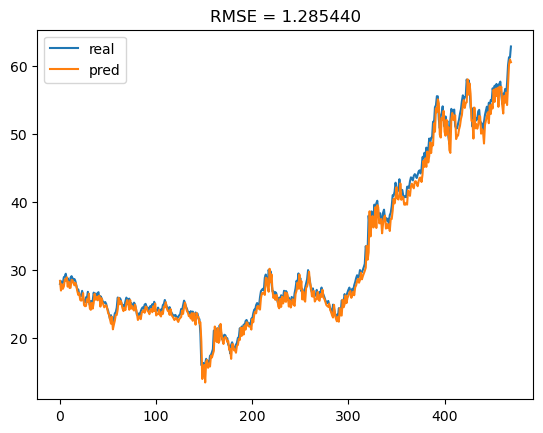

In [50]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(win_x, seq_len=30, random=False)
vis_model_performance(model_direct_lstm, Dtr, scalar)

## Win-SSA

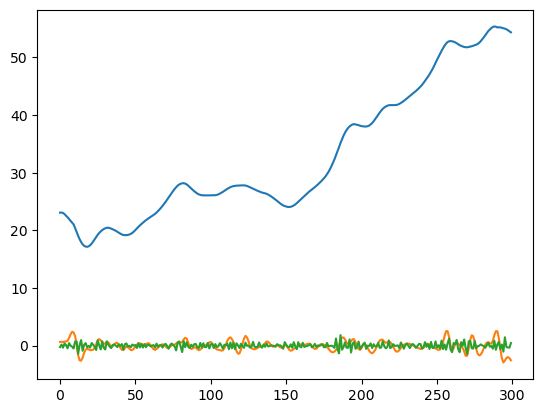

In [7]:
from series_restr import restr_ssa
reconstr = restr_ssa(win_x, n_decomp=10, n_integr=3)

plt.figure()
for i in range(len(reconstr)):
    plt.plot(reconstr[i])

In [8]:
from statsmodels.tsa import stattools
ssa_lo_freq = reconstr[0]
ssa_mi_freq = reconstr[1]
ssa_hi_freq = reconstr[2]
print(stattools.adfuller(ssa_lo_freq)[1])
print(stattools.adfuller(ssa_mi_freq)[1])
print(stattools.adfuller(ssa_hi_freq)[1])

0.9244824492630743
1.0240217673371821e-07
7.883692393873779e-20


-0.050184968732690544
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 100.296
Date:                Fri, 09 Jun 2023   AIC                           -188.593
Time:                        22:35:10   BIC                           -166.370
Sample:                             0   HQIC                          -179.699
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.045      9.166      0.000       0.326       0.503
ar.L2         -0.6284      0.036    -17.294      0.000      -0.700      -0.557
ma.L1         -2.5490      0.3

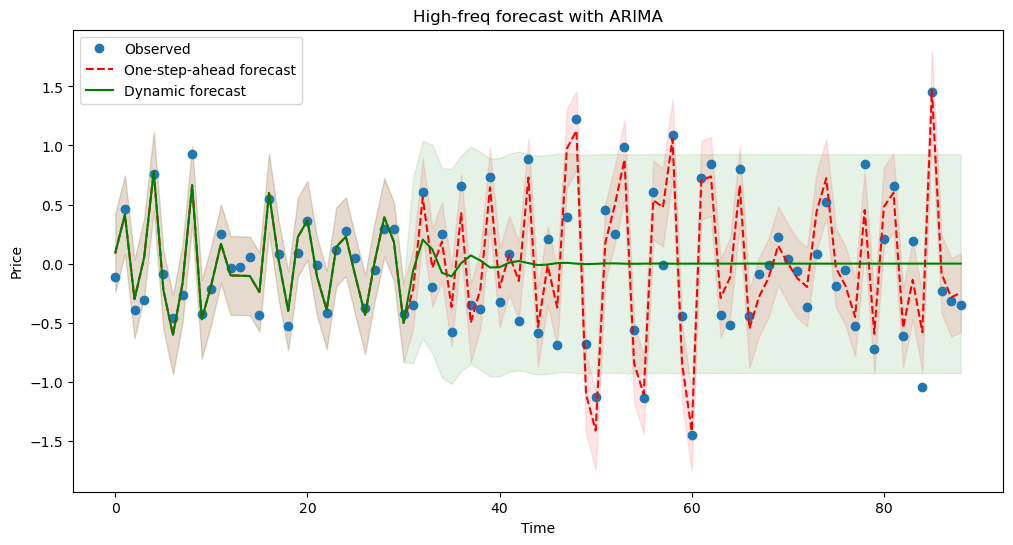

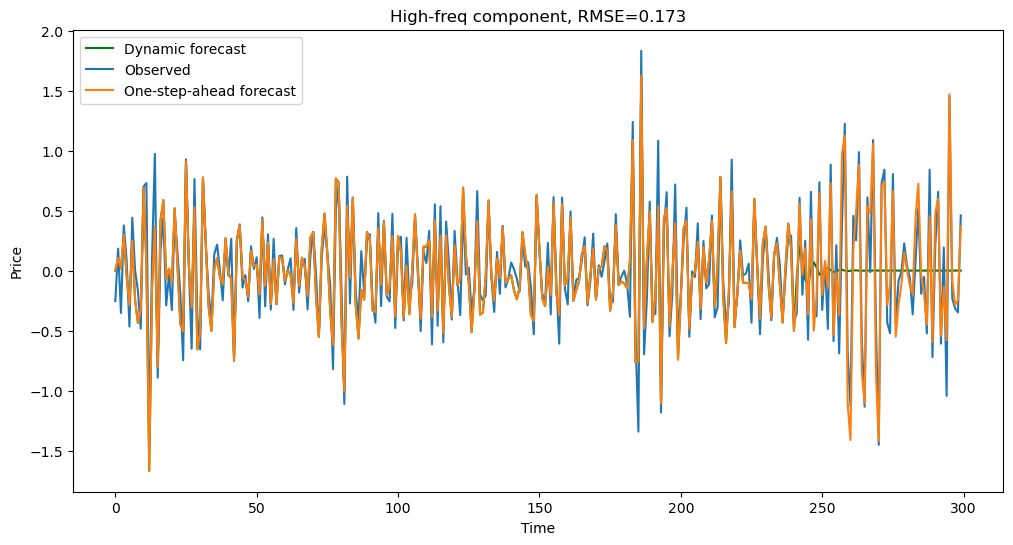

In [9]:
with HiddenPrints():
    ssa_hi_freq_pred, model_arima = forecast_arima(ssa_hi_freq)
print(ssa_hi_freq_pred)
plot_prediction(model_arima, ssa_hi_freq)

-2.3133650225909426
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(4, 0, 4)   Log Likelihood                 152.879
Date:                Fri, 09 Jun 2023   AIC                           -287.758
Time:                        22:35:16   BIC                           -254.424
Sample:                             0   HQIC                          -274.418
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6124      0.080     32.580      0.000       2.455       2.770
ar.L2         -2.9666      0.201    -14.748      0.000      -3.361      -2.572
ar.L3          1.8038      0.196

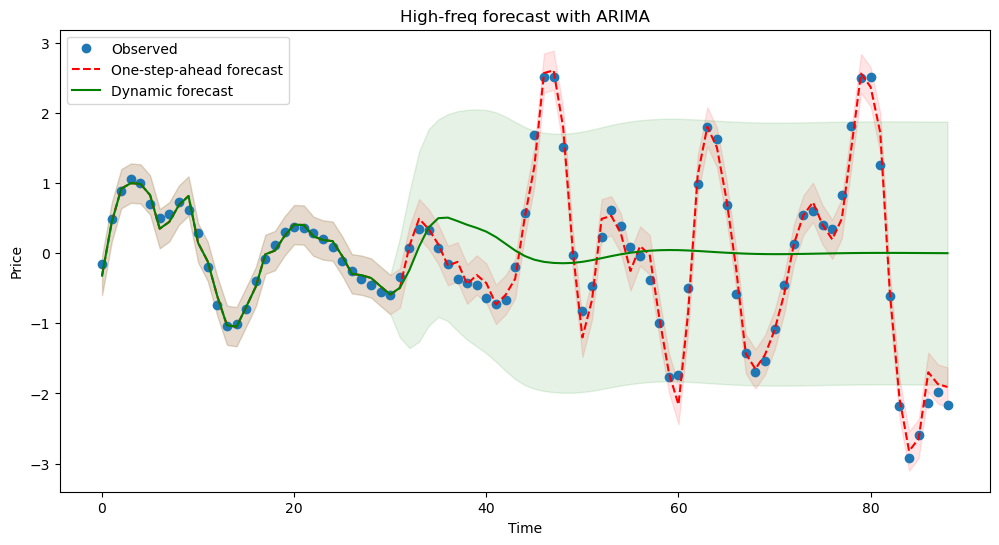

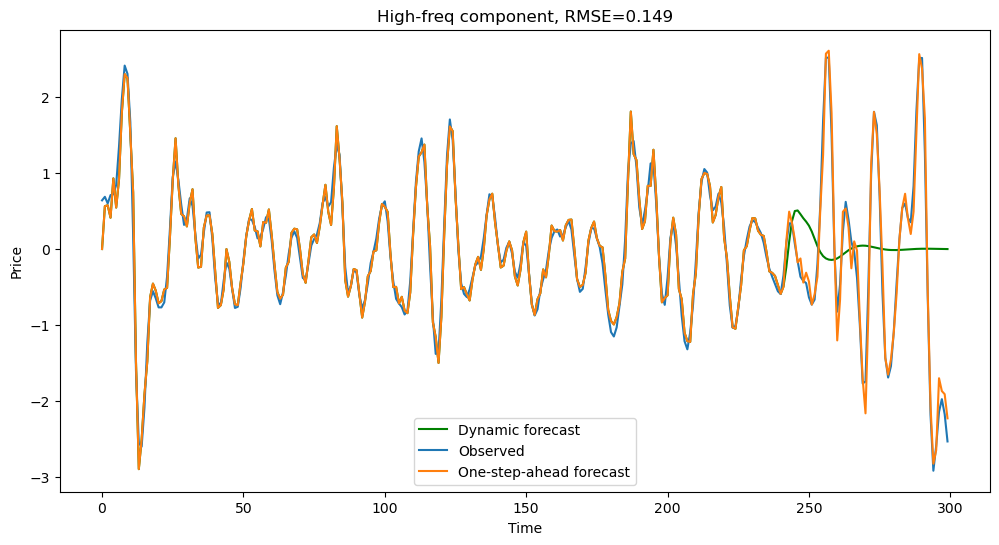

In [10]:
with HiddenPrints():
    ssa_hi_freq_pred, model_arima = forecast_arima(ssa_mi_freq)
print(ssa_hi_freq_pred)
plot_prediction(model_arima, ssa_mi_freq)

In [28]:
ssa_lo_freq_pred, model_tcn = forecast_TCN(ssa_lo_freq, 'ssa_tcn')
print(ssa_lo_freq_pred)


epoch 001 train_loss 0.04453675 val_loss 0.03519986
epoch 002 train_loss 0.02496326 val_loss 0.01179773
epoch 003 train_loss 0.01512724 val_loss 0.00481195
epoch 004 train_loss 0.01287799 val_loss 0.00279001
epoch 005 train_loss 0.00707601 val_loss 0.00442855
EarlyStopping counter: 1 out of 7
epoch 006 train_loss 0.00754679 val_loss 0.00290906
EarlyStopping counter: 2 out of 7
epoch 007 train_loss 0.00541509 val_loss 0.00212720
epoch 008 train_loss 0.00545814 val_loss 0.00190209
epoch 009 train_loss 0.00415101 val_loss 0.00132728
epoch 010 train_loss 0.00332452 val_loss 0.00128371
epoch 011 train_loss 0.00303870 val_loss 0.00128263
epoch 012 train_loss 0.00320303 val_loss 0.00115613
epoch 013 train_loss 0.00242471 val_loss 0.00128013
EarlyStopping counter: 1 out of 7
epoch 014 train_loss 0.00212922 val_loss 0.00125710
EarlyStopping counter: 2 out of 7
epoch 015 train_loss 0.00204941 val_loss 0.00101057
epoch 016 train_loss 0.00201044 val_loss 0.00118441
EarlyStopping counter: 1 out of 

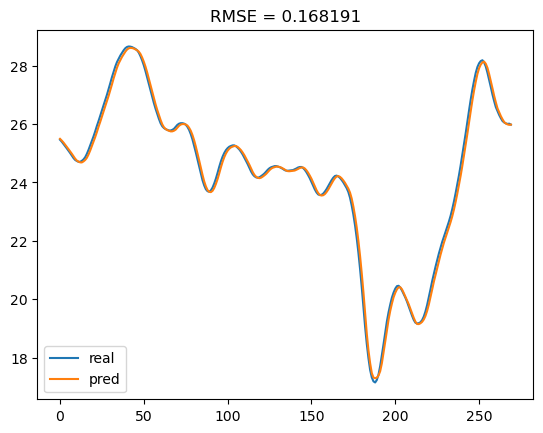

In [31]:
# visualize
Dtr, _, _, scalar = prepare_data_TCN(ssa_lo_freq, seq_len=30, random=False)
vis_model_performance(model_tcn, Dtr, scalar)

## SVR

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.metrics import r2_score


# x = 

x = np.random.randn(80, 2)
y = x[:, 0] + 2*x[:, 1] + np.random.randn(80)

clf = SVR(kernel='linear', C=1.25)
x_tran,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)
clf.fit(x_tran, y_train)
y_hat = clf.predict(x_test)

print("得分:", r2_score(y_test, y_hat))

r = len(x_test) + 1
print(y_test)
plt.plot(np.arange(1,r), y_hat, 'go-', label="predict")
plt.plot(np.arange(1,r), y_test, 'co-', label="real")
plt.legend()
plt.show()